In [1]:
! pip install -Uqq fastbook
from fastbook import *
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.PASCAL_2007)

path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/test')]

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [5]:
# lambda functions good for quickly prototyping, but do not support serialization
# which means we need to use actual, defined functions when the goal is to
# export a learner pkl
db = DataBlock(get_x=lambda r: r['fname'], get_y=lambda r: r['labels'])
dsets = db.datasets(df)

In [6]:
x,y = dsets.train[0]
x,y

('008663.jpg', 'car person')

In [7]:
db = DataBlock(
  blocks=(ImageBlock, MultiCategoryBlock),
  get_x=lambda r: path/'train'/r['fname'],
  get_y=lambda r: r['labels'].split(' '),
)
dsets = db.datasets(df)

In [8]:
x, y = dsets.train[0]
x,y

(PILImage mode=RGB size=500x332,
 TensorMultiCategory([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [9]:
def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train, valid

In [10]:
db = DataBlock(
  blocks=(ImageBlock, MultiCategoryBlock),
  splitter=splitter,
  get_x=lambda r: path/'train'/r['fname'],
  get_y=lambda r: r['labels'].split(' '),
)
dsets = db.datasets(df)

In [11]:
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [12]:
db = DataBlock(
  blocks=(ImageBlock, MultiCategoryBlock),
  splitter=splitter,
  get_x=lambda r: path/'train'/r['fname'],
  get_y=lambda r: r['labels'].split(' '),
  item_tfms=RandomResizedCrop(128, min_scale=.35)
)
loaders = db.dataloaders(df)

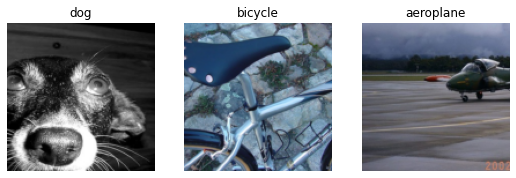

In [13]:
loaders.show_batch(nrows=1, ncols=3)

In [13]:
learn = vision_learner(loaders, resnet18)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [14]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [15]:
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [16]:
x,y = to_cpu(loaders.train.one_batch())
acts = learn.model(x)
acts.shape

torch.Size([64, 20])

In [18]:
acts[0]

TensorBase([ 3.9201,  4.8040, -0.0103, -3.2383, -1.1389, -1.1914,  1.3694, -2.6976, -0.2608, -0.8828, -3.6039,  1.0363,  3.6092, -0.6929, -2.1697,  3.7929,  3.0100,  0.9329,  1.6140,  3.7603],
           grad_fn=<AliasBackward0>)

In [19]:
loss_f = nn.BCEWithLogitsLoss()
loss = loss_f(acts, y)
loss

TensorMultiCategory(1.0477, grad_fn=<AliasBackward0>)

In [22]:
def _bce(acts, y):
  acts = acts.sigmoid()
  return -torch.where(y == 1., acts, 1-acts).log().mean()

In [23]:
_bce(acts, y)

TensorMultiCategory(1.0477, grad_fn=<AliasBackward0>)

In [24]:
learn = vision_learner(loaders, resnet34, metrics=partial(accuracy_multi, thresh=0.5))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.147719,0.120536,0.957331,00:05
1,0.128492,0.111906,0.960299,00:05
2,0.111854,0.109141,0.961036,00:06
